# Machine Learning in Python - Project 1

Due Friday, March 8th by 4 pm.

*Include contributors names in notebook metadata or here*

## Setup

*Install any packages here and load data*

In [67]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np
# !pip install statsmodels INSTALL
import statsmodels.api as sm
# !pip install openpyxl
import openpyxl
from scipy import stats

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80
sns.color_palette("hls", 12)

# Dataframe embellishment defaults
    # Formatting of index column as italics with grey font.
index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
}

    # Formatting of headers with blue tone used in document palette.
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #586b7a; color: white;'
}  

# sklearn modules
import sklearn
from sklearn.pipeline import Pipeline
from sklearn import preprocessing as pp
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split



In [3]:
# Load data in easyshare.csv
df = pd.read_csv("easyshare.csv")

In [4]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])


def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsqr) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return Metrics

# Introduction

***This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a professional body (e.g. European Union, Governments, Health Institutes and/or Charities on dementia and ageing). If you use any additional data sources, you should introduce them here and discuss why they were included.***

***Briefly outline the approaches being used and the conclusions that you are able to draw.***

The world's population distribution is shifting towards the predominance of ageing people, following continuous years of scientific developments that have positively impacted human beings' life expectancy. In 2018, the number of people in the world aged 65 or above surpassed people under 5 years old for the first time in history<sup>1</sup>. Moreover, by 2030, 1 out of 6 people are expected to be 60 or above and the number of people aged 80 or above are expected to triple by 2050 -versus 2020-<sup>2</sup>. These statistics reflect an ageing world population, as is consistent with the observed trend in life expectancy, which was recorded at around 73 years old for 2023, representing a gain of 10 years of life for the world's average person today versus 40 years ago.

Although these demographic figures have an encouraging flavour for humankind, the progression of the average human lifetime in years does not come without a cost. One of the adversities raised by this overall positive scenario for humanity is the prevalence of costly age-related diseases, like dementia. According to the World Health Organisation (WHO), currently over 55 million people live with dementia and this number is expected to almost triple by 2050<sup>3</sup>. In 2020, the annual cost of dementia was estimated at a staggering figure of US$818 billion and is expected to reach US$2 trillion by 2030, mostly due to familiar and social costs (not strictly medical care)<sup>4</sup>.

Fortunately, these projections are not unavoidable. As previous studies have shown (Livingstone et al. (2017), Livingstone et al. (2020), GBD 2016 Dementia Collaborators (2016)), there are over nine modifiable risks for dementia, which include less education, smoking, obesity, physical inactivity, low social contact, excessive alcohol consumption, among others. For this reason, the European Union seeks to better understand how these factors' impact on dementia severity, as this is key to develop prevention policies at a country, regional and worldwide level to reduce the social costs of this disease. 

In that regard, the purpose of this study is to adequately estimate the relationship between dementia severity and diverse demographic and health factors adding to the current academic literature on the subject, and from this estimation suggest policy areas that may be wise to focus by both the European Union and other governmental and non-governmental institutions. For this objective, we use the easySHARE data which is a simplified dataset of the panel data generated from the distinct waves (surveys in time) of the Survey of Health, Ageing and Retirement in Europe (SHARE). This dataset aims to provide data on European individuals as they age and their environment. The easySHARE database to use contains 22 variables, with observations recorded at a individual level, with one observation per individual (although different observations may correspond to different waves of SHARE).

This study will explore supervised machine learning methods, focusing specifically on estimating a regression model for easySHARE individuals' cognitive score, which will be used as a proxy variable for dementia severity, using modifiable risk factors identified by previous literature and exploring new posible factors of interest.

*“This paper uses data from the generated easySHARE data set (DOI: 10.6103/SHARE.easy.800), see Gruber et al. (2014) for methodological details. The easySHARE release 8.0.0 is based on SHARE Waves 1, 2, 3 (SHARELIFE), 4, 5, 6, 7 and 8 (DOIs: 10.6103/SHARE.w1.800, 10.6103/SHARE.w2.800, 10.6103/SHARE.w3.800, 10.6103/SHARE.w4.800,10.6103/SHARE.w5.800, 10.6103/SHARE.w6.800, 10.6103/SHARE.w7.800, 10.6103/SHARE.w8.800)”*

# Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.*

*You should also split your data into training and testing sets, ideally before you look to much into the features and relationships with the target*

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. Feature engineering that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*If you decide to extract additional features from the full data (easyshare_all.csv), describe these variables here.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

Before modelling dementia severity (proxied by cognitive score, as mentioned in the study's introduction), we proceed to explore the easySHARE database to better understand the features we have available for our task.

In [5]:
# Visualize numerical columns in data
descr_stats = df.describe(include = [np.number]).round(2)
s = descr_stats.style.format('{:.0f}')

# Apply formatting to descriptive table
print(f'The easySHARE database contains {df.shape[0]} obsrvations of {df.shape[1]} variables.')
s.set_table_styles([index_names, headers])

The easySHARE database contains 98348 obsrvations of 23 variables.


,int_year,wave,country,country_mod,female,age,birth_country,citizenship,isced1997_r,eduyears_mod,eurod,bmi,bmi2,smoking,ever_smoked,br010_mod,br015_,casp,chronic_mod,sp008_,ch001_,cogscore
count,97372,97372,97372,97372,97372,97372,97170,97281,97372,84532,95838,94686,94686,96887,97116,79210,97113,84065,97283,83175,96928,97372
mean,2010,4,24,385,1,68,398,392,3,10,3,27,3,4,3,3,3,37,1,4,2,12
std,5,2,12,229,0,9,238,233,1,4,2,5,1,1,2,2,1,6,1,2,1,4
min,2004,1,11,40,0,55,2,4,0,0,0,13,1,1,1,1,1,12,0,1,0,0
25%,2006,2,15,208,0,60,208,208,1,8,1,24,2,5,1,1,1,32,0,1,1,9
50%,2011,4,20,300,1,67,348,348,3,11,2,26,3,5,5,3,3,37,1,5,2,12
75%,2013,5,31,616,1,74,642,620,3,13,4,29,3,5,5,5,4,42,2,5,3,15
max,2020,8,63,756,1,112,1101,1132,6,30,12,87,4,5,5,7,4,48,9,5,17,26


As presented in the table above, the easySHARE database includes 23 variables, which describe the following data:
- *mergeid*: person identifier
- *wave*: wave identifier
- *country*: country identifier
- *country_mod*: modified country identifier
- *female*: dummy encoded gender with 0 for male and 1 for female
- *age*: age at interview
- *birth_country*: country of birth
- *citizenship*: citizenship of respondent
- *isced1997_r*: ISCED-97 encoding of education (6 levels - see pg. 11 of data guide)
- *eduyears_mod*: years of education
- *eurod*: depression scale ranging from 0 “not depressed” to 12 “very depressed”
- *bmi*: body mass index
- *bmi2*: categorized body mass index
- *smoking*: smoke at present time
- *ever_smoked*: ever smoked daily
- *br010_mod*: drinking behavior
- *br015_*: vigorous activities
- *casp*: CASP-12 score measures quality of life and is based on four subscales on control,
autonomy, pleasure and self-realization, ranges from 12 to 48
- *chronic_mod*: number of chronic diseases
- *sp008_*: gives help to others outside the household
- *ch001_*: number of children
- *cogscore*: measure of cognitive function combining results from two numeracy tests, two
word recall tests, and an orientation test.

From the start, it is evident that the variables on easySHARE have different counts, which is due to the remark by SHARE that not all variables were collected in every wave. Moreover, smaller differences in the counts of variables could be due to individuals not answering some of the questions in the survey.

We also identify that some categorical variables in the database have been coded in an ordinal manner, while the steps between each category may not necessarily have the same contribution to dementia severity (i.e.: the effect of an inidividual going from underweight to normal weight in the variable *bmi2* would likely be significantly different on the cognitive score of this person than the effect if they go from overweight to obese.). This is something we will likely have to explore as possible alternatives in the modelling section of this study.

Finally, from this descriptive table we can see that some of our continuous variables start at zero, which may pose challenges if we need to perform Box-Cox transformations as part of our feature engineering<sup>5</sup>. 

Text(0.5, 1.015, 'Histograms of Non-ID Variables in easySHARE')

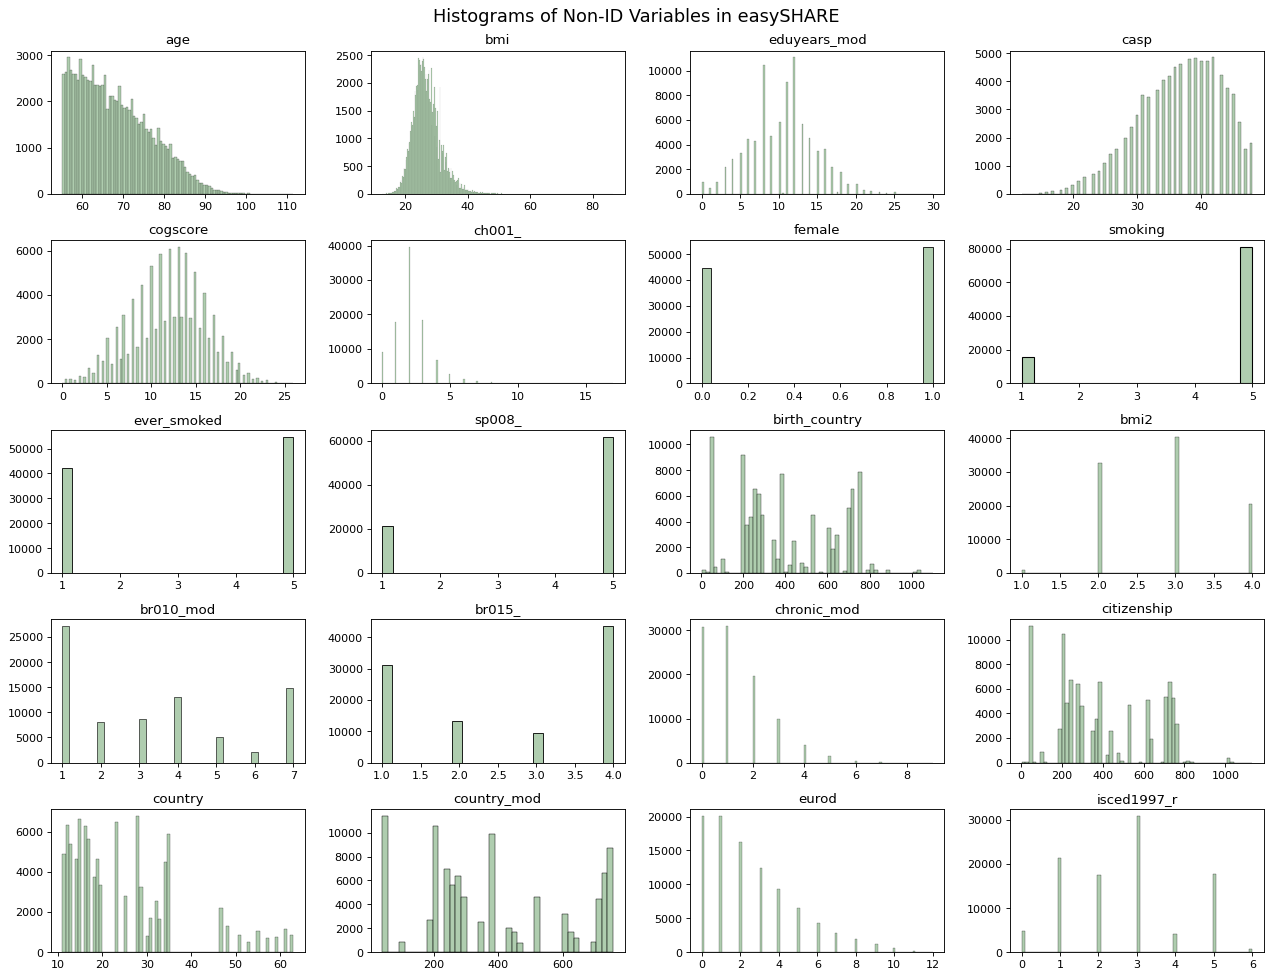

In [6]:
# Initial Data Exploration
#df.info()

    ## There are no missing values (unanswered, etc) according to the codes listed 
    ## in the data description file.

# List of columns per type of variable
id_vars = ['int_year','wave','mergeid']     # ID variables
numerical_vars = ['age','bmi','eduyears_mod','casp','cogscore','ch001_']     # Non-categorical variables
binary_vars = ['female','smoking','ever_smoked','sp008_']     # Binary variables
cat_vars = np.setdiff1d(df.columns,id_vars + numerical_vars + binary_vars).tolist()     # Categorical variables (n>2)

#len(cat_vars+binary_vars+numerical_vars+id_vars)==len(df.columns) # Checking no variables are missing

# Explore variable distributions through histograms
non_id_vars = numerical_vars + binary_vars + cat_vars # Get vector of all variables to plot with histograms
#len(non_id_vars)                            # 20 variables are non_id

# Figure plot area and settings
fig, ax = plt.subplots(figsize = (16, 12))
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

# For-loop to create histograms
for n, col in enumerate(non_id_vars):
    plt.subplot(5, 4, n+1)
    a = sns.histplot(df[col],ax = plt.gca(),color='#95bd95')
    a.set(xlabel=None, ylabel=None)
    a.set_facecolor('white')
    plt.title(col)

plt.tight_layout()
plt.suptitle("Histograms of Non-ID Variables in easySHARE", fontsize=16,y=1.015)
#print("What is happening with cogscore? There seems to be two distributions")

As is apparent in the histograms above, the features in easySHARE have a variety of scales. Moreover, most do not present a normal -or similar- distribution. Some of the histograms are heavy-tailed: they extend farther to the right/left of the median than to the left/right. This may make it a bit harder for some algorithms to detect patterns. Both of these characteristics suggest we may need to consider normalizing, and possibly performing Box-Cox transformations, to the factors that are incorporated in the models to fit later in this study.

Nonetheless, it is worth mentioning that a good proportion of our available features are skewed count or categorical variables (some of which have significant density at value 0, as is the case with *eurod* and *chronic_mod*). Adequately managing these features' characteristics requires some additional subtlety, especially when handling their outliers and when trying to transform them to more normal-like distributions to be able to do inference with their coefficients in the models.

In order to better understand the peculiarities of the variables in our dataset and which transformations may be necessary prior to the modelling stage, we will proceed to explore the boxplots of the available features.

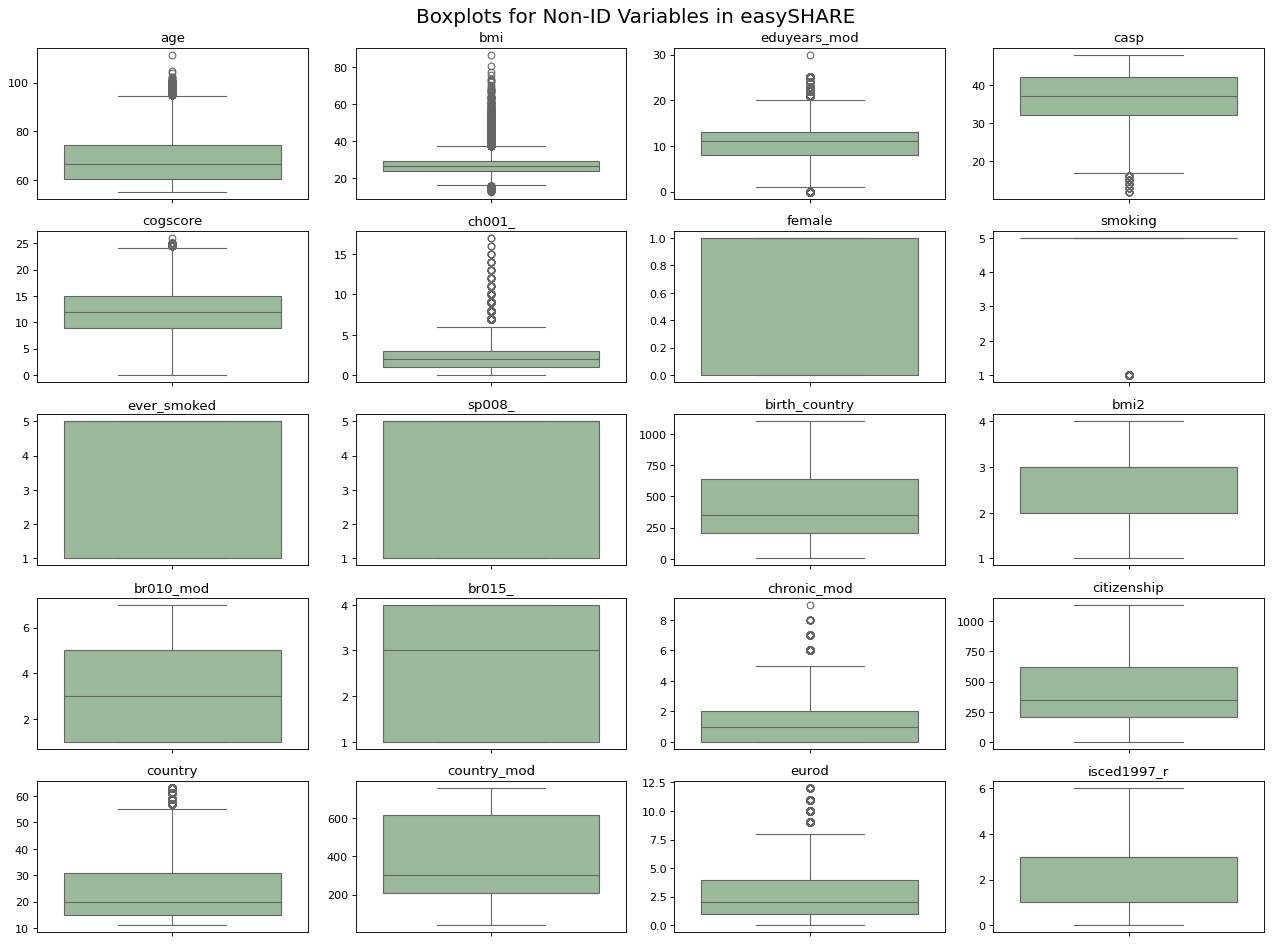

In [7]:
# Generating Box-Plots for Non-ID Variables
fig, axes = plt.subplots(figsize = (16, 12), ncols = 4, nrows=5, sharex = True)
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.boxplot(y = df[non_id_vars].values[:,i], ax = ax,color='#95bd95') 
    ax.set_title(non_id_vars[i])
    ax.set_ylabel("")
    
plt.suptitle("Boxplots for Non-ID Variables in easySHARE", fontsize=18)
plt.tight_layout()

As was previsible, some of the dataset's features have a significant amount of outliers. It is worth differentiating the outlier treatment we suggest for these variables:

- *age*: Given we want to estimate dementia severity, which is tightly linked to age, removing the outliers for this variable would be inadequate, because it would reduce the capacity of our model to estimate dementia severity for people in higher percentiles of age.

- *bmi*: Although this variable seems to have an important amount of outliers, its categorical transformation *bmi2*, does not, and would have more intuitive interpretation in a prediction model.

- *eurod*: This variable is a categorical feature that represents how depressed the surveyed individual is. Thus, removing its outliers would remove the more extreme categories (i.e.: 12 stands for 'very depressed') and therefore reduce the capacity of our model to estimate dementia severity for people most affected by depression.

- *casp*: The outliers in this variable, which is an index representing quality of life, are found in the lower-end of its distribution, which would be associated to a higher risk of high dementia severity. For this reason, similar to the logic used for the previous variables, we decide to keep the outliers.

- *eduyears_mod*, *ch001_* and *chronic_mod*: Given these variables are counts (education years, number of children and number of chronic diseases) whose extremes may not be as useful to distinguish from its upper values (i.e.: Someone with a PhD education would most likely have a similar dementia severity prediction based on this feature alone that someone with a post-Doctoral degree), we suggest handling these outliers through winsorization, as is suggested for skewed counts<sup>6</sup>.

Now, we will proceed to clean our data and explore if winsorization does indeed improve the outliers in these distributions.

In [8]:
# Data Cleaning

# Creating a copy of dataframe where all data cleaning and transformations will be stored
df_transformations = df.copy()

# Drop the null values
df_transformations = df_transformations.dropna()

# We have no duplicated values :)
#df_transformations.duplicated().sum()

# Check null values per column
#df_transformations.isna().sum(axis = 0)

In [9]:
# Winsorizing eduyears_mod, chronic_mod and ch001_
# Finding the 99th (upper bound) and 1st (lower bound) percentiles for each variable to winsorize

# Bounds for years of education
upper_lim_edu = df['eduyears_mod'].quantile(0.99)
lower_lim_edu = df['eduyears_mod'].quantile(0.01)

# Bounds for chronic diseases    
upper_lim_chr = df['chronic_mod'].quantile(0.99)
lower_lim_chr = df['chronic_mod'].quantile(0.01)

# Bounds for number of children
upper_lim_child = df['ch001_'].quantile(0.99)
lower_lim_child = df['ch001_'].quantile(0.01)

# Replacing original variables with winsorized vectors
df_transformations['eduyears_mod'] = np.where(df_transformations['eduyears_mod'] >= upper_lim_edu,
                        upper_lim_edu,
                        np.where(df_transformations['eduyears_mod'] <= lower_lim_edu,
                        lower_lim_edu,
                        df_transformations['eduyears_mod']))

df_transformations['chronic_mod'] = np.where(df_transformations['chronic_mod'] >= upper_lim_chr,
                        upper_lim_chr,
                        np.where(df_transformations['chronic_mod'] <= lower_lim_chr,
                        lower_lim_chr,
                        df_transformations['chronic_mod']))

df_transformations['ch001_'] = np.where(df_transformations['ch001_'] >= upper_lim_child,
                        upper_lim_child,
                        np.where(df_transformations['ch001_'] <= lower_lim_child,
                        lower_lim_child,
                        df_transformations['ch001_']))


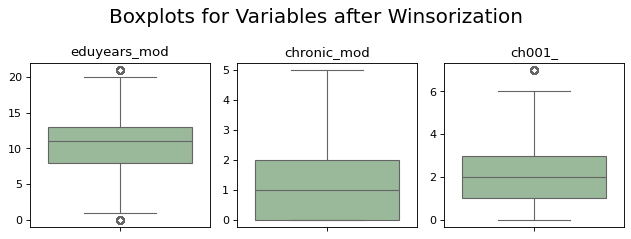

In [10]:
# Generating boxplots after winsorization

# Vector of variables that were winsorized
winsor_vars = ['eduyears_mod','chronic_mod','ch001_']

fig, axes = plt.subplots(figsize = (8, 3), ncols = 3, nrows=1, sharex = True)
axes = axes.flatten()
winsor_vars_values = df_transformations[winsor_vars].values

for i, ax in enumerate(axes):
    sns.boxplot(y = winsor_vars_values[:,i], ax = ax, color='#95bd95') 
    ax.set_title(winsor_vars[i])
    ax.set_ylabel("")
    
plt.suptitle("Boxplots for Variables after Winsorization", fontsize=18)
plt.tight_layout()


Indeed, winsorizing *eduyears_mod*, *chronic_mod* and *ch001_* with their 99th and 1st percentiles as bounds helped to regularize the outliers for these features. 

Moving forward, we will explore the normality for the standardized version of the numerical features (count and continuous variables) in our dataset.

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


Text(0.5, 0.98, 'Q-Q Plots of Numerical Variables in easySHARE')

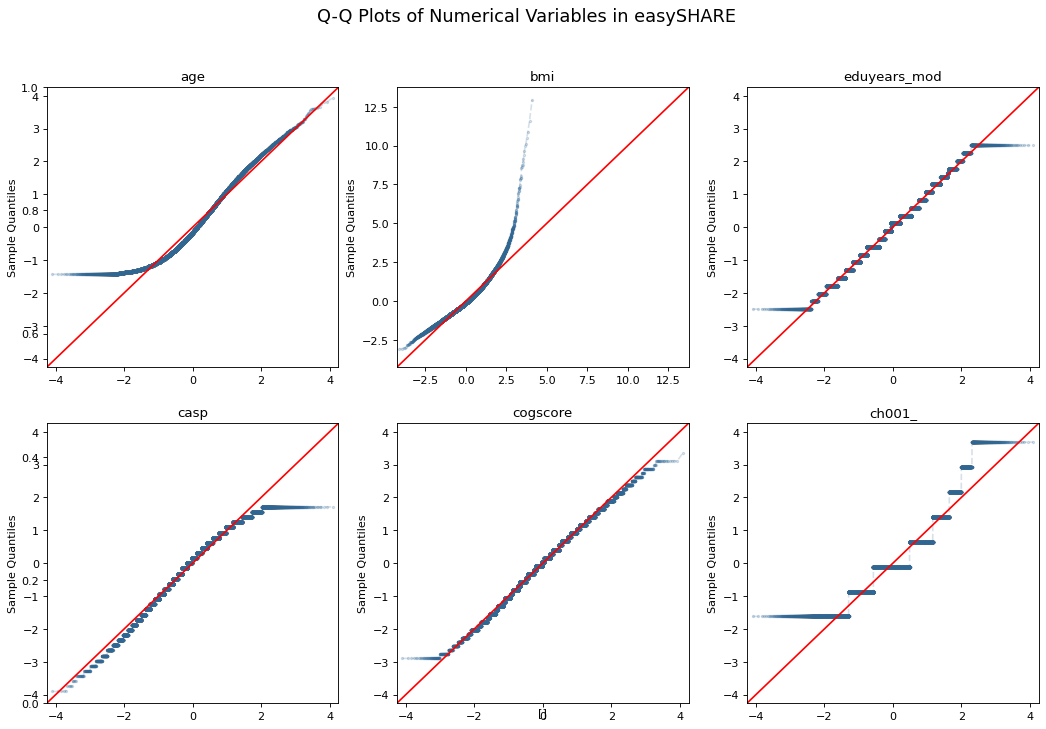

In [11]:
# Q-Q Plot Exploration of Normality for Numerical Variables 
# in easySHARE

# Standardization of the Numerical Variables in easySHARE
std_numerical_df = df_transformations[numerical_vars].values #returns a numpy array
std_numerical_df = pp.StandardScaler().fit_transform(std_numerical_df)
std_numerical_df = pd.DataFrame(std_numerical_df, columns=numerical_vars)

fig, axs = plt.subplots(figsize=(16, 10))
axs.set_frame_on(False)
axs.set_xticks([])
axs.set_xlabel([])

for n, col in enumerate(numerical_vars):
    plt.subplot(2, 3, n+1)
    sm.qqplot(std_numerical_df[col], ax=plt.gca(), line='45', fit=False,
                **{'markersize':2, 'alpha':0.2,'markeredgecolor':'#3a6791',
                'linestyle':'dashed','color':'#3a6791'})
    plt.title(col)
    plt.xlabel('')

fig.suptitle('Q-Q Plots of Numerical Variables in easySHARE', fontsize=16)


The numerical features in our dataset somewhat resemble skewed normal distributions with tails that are fatter/lighter than the normal, depending on the variable. Particularly, *bmi* is the farthest away from a normal distribution, as was to be expected mainly because of the heavy prevalence of outliers that were identified in the earlier shown boxplot of the variable. Furthermore, the count variables have more of a step-wise distribution (*ch001_* and *eduyears_mod*) with lower boundaries positioned above a normal that accumulate more density (cannot have less than 0 children or years of education) and some outliers at the higher extreme.

To improve the skewness present in our variables and allow for inference in this study's modelling stage, we will proceed to evaluate Box-Cox transformations for our numerical variables by finding the $\lambda$ that maximizes the log-likelihood function. It is relevant to note that 0.01 will be added to the count variables prior to the $\lambda$ optimization, given that these have significant density at value 0 and $\log(0)$ is not defined<sup>7</sup>. 

In [12]:
# Finding optimal lambda for non-normal variables.
age_box_, bc_age_param = stats.boxcox(df_transformations['age'].astype(int), lmbda = None)
print(f'The lambda that maximizes the log-likelihood function for the variable age is {round(bc_age_param,2)}.')

cs_box_, bc_cs_param = stats.boxcox(df_transformations['cogscore'].astype(float), lmbda = None)
print(f'The lambda that maximizes the log-likelihood function for the variable cogscore is {round(bc_cs_param,2)}.')

casp_box_, bc_casp_param = stats.boxcox(df_transformations['casp'].astype(float), lmbda = None)
print(f'The lambda that maximizes the log-likelihood function for the variable casp is {round(bc_casp_param,2)}.')

bmi_box_, bc_bmi_param = stats.boxcox(df_transformations['bmi'].astype(float), lmbda = None)
print(f'The lambda that maximizes the log-likelihood function for the variable bmi is {round(bc_bmi_param,2)}.')

eduyrs_box_, bc_eduyrs_param = stats.boxcox((df_transformations['eduyears_mod']+0.01).astype(float), lmbda = None)
print(f'The lambda that maximizes the log-likelihood function for the variable eduyears_mod is {round(bc_eduyrs_param,2)}.')

ch001_box_, bc_ch001_param = stats.boxcox((df_transformations['ch001_']+0.01).astype(float), lmbda = None)
print(f'The lambda that maximizes the log-likelihood function for the variable ch001_ is {round(bc_ch001_param,2)}.')

The lambda that maximizes the log-likelihood function for the variable age is -1.56.
The lambda that maximizes the log-likelihood function for the variable cogscore is 1.06.
The lambda that maximizes the log-likelihood function for the variable casp is 2.04.
The lambda that maximizes the log-likelihood function for the variable bmi is -0.52.
The lambda that maximizes the log-likelihood function for the variable eduyears_mod is 0.87.
The lambda that maximizes the log-likelihood function for the variable ch001_ is 0.63.


/home/codespace/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/home/codespace/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


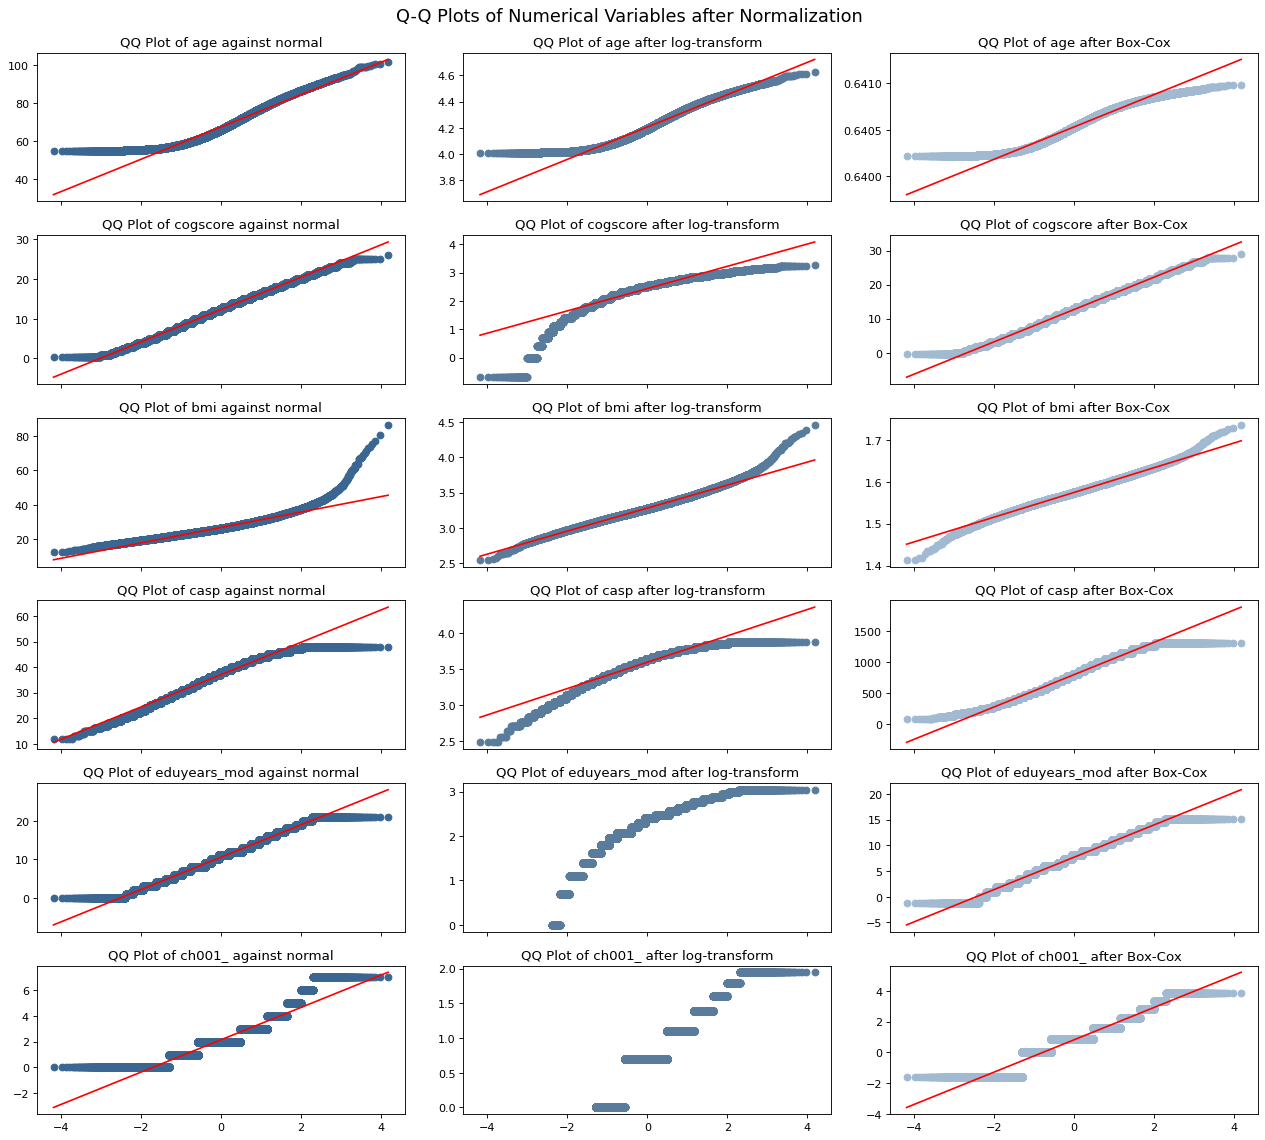

In [13]:
# adapted from Feature Engineering for Machine Learning principles and 
# techniques for data scientists, used from Workshop 1?

# List of variables we applied Box-Cox transformation to
boxcox_list = ['age','cogscore','bmi','casp','eduyears_mod','ch001_']

# Dataframe with columns we applied Box-Cox transformation to
boxcox_df = df_transformations[boxcox_list]

# List of optimal lambda parameters we obtained
best_lambdas = [bc_age_param, bc_cs_param, bc_bmi_param, bc_casp_param, bc_eduyrs_param, bc_ch001_param]

# Graph to compare QQ Plots pre and post log-transformation and
# Box-Cox transformation using optimal lambda from prior code chunk
fig2, axs = plt.subplots(6,3, figsize=(16,14), sharex=True) 

# For loop to create 3 comparison plots for each variable
for i in range(len(axs)):
    # QQ Plot of Original Variable Data
    prob1 = stats.probplot(boxcox_df[boxcox_list[i]].astype(float), dist=stats.norm, 
    plot=axs[i][0])     # Plot original data 
    axs[i][0].set_xlabel('')
    axs[i][0].set_ylabel('') 
    axs[i][0].set_title(f'QQ Plot of {boxcox_list[i]} against normal') 
    axs[i][0].get_lines()[0].set_markerfacecolor('#3a6791')
    axs[i][0].get_lines()[0].set_markeredgecolor('#3a6791')

    # QQ Plot of Log-Transformed Variable Data
    var_logtrans_ = stats.boxcox(boxcox_df[boxcox_list[i]].astype(float), lmbda=0.)
    prob2 = stats.probplot(var_logtrans_, dist=stats.norm, plot=axs[i][1]) 
    axs[i][1].set_xlabel('') 
    axs[i][1].set_ylabel('') 
    axs[i][1].set_title(f'QQ Plot of {boxcox_list[i]} after log-transform')
    axs[i][1].get_lines()[0].set_markerfacecolor('#5a7c9c')
    axs[i][1].get_lines()[0].set_markeredgecolor('#5a7c9c')

    # QQ Plot of Box-Cox Transformed Variable Data
    var_boxcox_ = stats.boxcox(boxcox_df[boxcox_list[i]].astype(float), lmbda=best_lambdas[i])
    prob3 = stats.probplot(var_boxcox_, dist=stats.norm, plot=axs[i][2]) 
    axs[i][2].set_xlabel('') 
    axs[i][2].set_ylabel('') 
    axs[i][2].set_title(f'QQ Plot of {boxcox_list[i]} after Box-Cox')
    axs[i][2].get_lines()[0].set_markerfacecolor('#a1bad1')
    axs[i][2].get_lines()[0].set_markeredgecolor('#a1bad1')

plt.tight_layout()
fig2.suptitle('Q-Q Plots of Numerical Variables after Normalization', fontsize=16,y=1.015)
plt.show()


From the normalization of these variables, we can identify *bmi* is the one significantly benefited by any transformation. In general, log-transformation was not beneficial for any of the variables, and for the rest of the numerical features, Box-Cox transformation using their optimal $\lambda$ did not significantly improve the normality (they were visibly close enough to a normal).

Before implementing the last steps of our feature engineering process, we will proceed to explore the correlations and possible relationships between our available features.

Text(0.5, 0.95, 'Heatmap of Non-ID Variables in easySHARE')

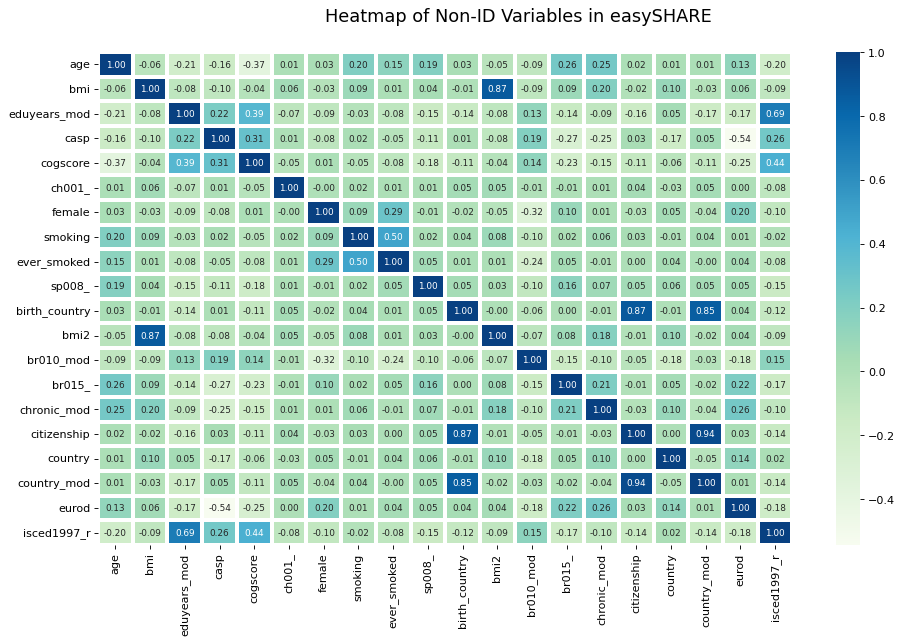

In [14]:
# Plot a heat map to check if any of the features are correlated
from matplotlib import rcParams
rcParams['figure.figsize'] = 14,8
#sns.set(rc={'figure.figsize': (14, 8)})
sns.heatmap(df_transformations[non_id_vars].corr(),cmap="GnBu", annot = True,
            fmt = '.2f',  linewidths = 2, annot_kws={"size": 8})
plt.suptitle('Heatmap of Non-ID Variables in easySHARE',fontsize=16,y=0.95)


As expected, *bith_country*, *country_mod* and *citizenship* have a high positive correlation; as do *eduyears_mod* and *isced1997_r* (ISCED-97 coding of education level), and *bmi* and *bmi2*. This serves as a reminder to choose only one of the representation of demographic factors (continuos vs categorical). Additionally, *eurod* (depression level) and *casp* (quality of life) seem to have medium correlation. Other than this, factors do not seem to have high correlation amongst themselves, thus, it is not evident from the start that any of the other variables could bring collinearity issues to the models. 

Moreover, we can observe that there is some correlation ($\geq$ $\lvert0.2\rvert)$) between our dependent variable of interest, *cogscore*, and the following variables:

- **Education**: *isced1997_r* and *eduyears_mod*
- **Depression**: *eurod*
- **Physical activity**: *br015_*
- **Age**: *age*
- **Quality of life**: *casp*

We will proceed to investigate the scatter plots between *cogscore* and each of these variables in order to identify possible model functional forms.

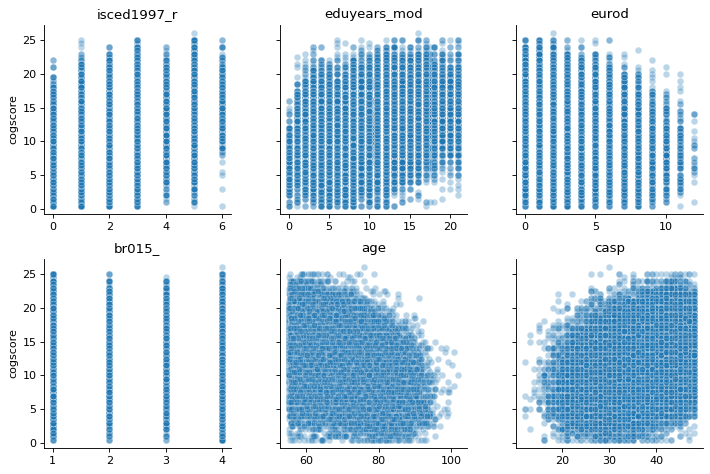

In [15]:
# "Pairplot" equivalent
vars_corr = ['isced1997_r','eduyears_mod','eurod',
                      'br015_','age','casp']
vars_corr_cs = vars_corr + ['cogscore']                      
corr_df = df_transformations[vars_corr_cs]

# Creating Facet Grid
g = sns.FacetGrid(pd.DataFrame(vars_corr), col=0, col_wrap=3, sharex=False)
# Plotting scatterplots
for ax, varx in zip(g.axes, vars_corr):
    sns.scatterplot(data=corr_df, x=varx, y="cogscore", ax=ax,
    alpha=0.3).set_title(varx)
    ax.set_xlabel("")

# plt.suptitle('Scatter Plot of Variables Correlated to Cognitive Score', y=1.02)
# # g.tight_layout()

At first hand, no obvious relationships are aparent functional forms between our possible continuous independent variables and *cogscore*. However, we would expect a indirect relationship between *age* and *cogscore* (as it to be expected: on average lower cognitive score for older people), and a direct relationship between *casp*/*eduyears_mod* and *cogscore* (as it to be expected: on average higher cognitive score for people with higher life quality and education).

Having explored these relationships, we will proceed to do some final data transformations and go on with the modelling stage.

In [16]:
# Data Transformation

# Replacing smoking value 5 (non-smoker) for 0.
for i in binary_vars:
    df_transformations[i] = np.where(df_transformations[i] == 5, 0,df_transformations[i])

bmi2_vals = ['underweight','normal','overweight','obese']
br010_vals = ['no_drink','less1mo_drink','cple1mo_drink','cple1wk_drink',
            '4wk_drink','6wk_drink','daily_drink']
br015_vals = ['more1wk_act','1wk_act','mnthly_act','hardly_act']

df_transformations['bmi2'] = np.where(df_transformations['bmi2'].astype(int)==1,
                        bmi2_vals[0],
                        np.where(df_transformations['bmi2'].astype(int)==2,
                        bmi2_vals[1],
                        np.where(df_transformations['bmi2'].astype(int)==3,
                        bmi2_vals[2],
                        bmi2_vals[3])))

df_transformations['br015_'] = np.where(df_transformations['br015_'].astype(int)==1,
                        br015_vals[0],
                        np.where(df_transformations['br015_'].astype(int)==2,
                        br015_vals[1],
                        np.where(df_transformations['br015_'].astype(int)==3,
                        br015_vals[2],
                        br015_vals[3])))

df_transformations['br010_mod'] = np.where(df_transformations['br010_mod'].astype(int)==1,
                        br010_vals[0],
                        np.where(df_transformations['br010_mod'].astype(int)==2,
                        br010_vals[1],
                        np.where(df_transformations['br010_mod'].astype(int)==3,
                        br010_vals[2],
                        np.where(df_transformations['br010_mod'].astype(int)==4,
                        br010_vals[3],
                        np.where(df_transformations['br010_mod'].astype(int)==5,
                        br010_vals[4],
                        np.where(df_transformations['br010_mod'].astype(int)==6,
                        br010_vals[5],
                        br010_vals[6]))))))




In [17]:

# DATA PARTITIONING

# Set a seed for reproducibility of results
rng = np.random.seed(21701)

# First split off features and targets
# X = df.drop(['mergeid', 'cogscore'], axis = 1) # Set of features
features = ['age','bmi','eduyears_mod','casp','ch001_','female',
            'smoking','ever_smoked','sp008_','bmi2','br010_mod',
            'br015_','chronic_mod','eurod','isced1997_r']

X = df_transformations[features]
y = df_transformations['cogscore']

# We shuffle the data so the countries get mixed up
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)

# Do we want to do 80-10-10 to include a validation set? 
# Alternatively, we do CV in the end which may be better
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

# print("X_val:", X_val.shape)
# print("y_val:", y_val.shape)

X_train: (38012, 15)
y_train: (38012,)
X_test: (9503, 15)
y_test: (9503,)


# Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. linear regression, interaction terms, lasso, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validating it.*

*For example if you considered a linear regression model, a polynomial regression, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

*Finally, you should also provide comparison of your model with baseline model(s) on the test data but only briefly describe the baseline model(s) considered*

We will build our model from the ground up. Given the scatterplots did not show any obvious relationship between the variables, we use the information shown by the correlation matrices and the previous literature as reference, starting off with a model that includes obesity, smoking, education, drinking behavior, physical activity level, quality of life and age as predictors.

0.283


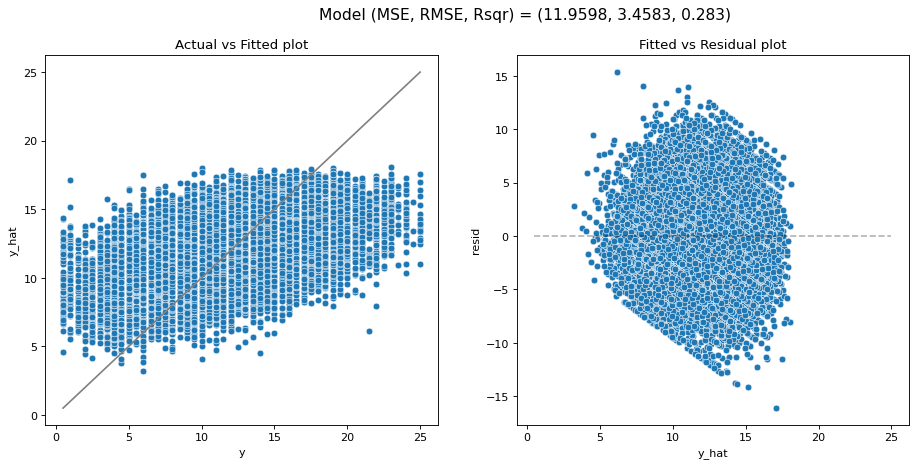

[12.  1.  1. -1. -0. -0.]
[['intercept' 12.3235]
 ['eduyears_mod' 1.1366]
 ['casp' 0.6653]
 ['age' -1.1469]
 ['eurod' -0.3367]
 ['smoking' -0.1818]]


In [18]:
# Baseline model

# Baseline features
baseline_features = ['eduyears_mod', 'casp','age','eurod','smoking']
X_train_bs, X_test_bs = X_train[baseline_features], X_test[baseline_features]

# Setting up the pipeline for the baseline model
num_pre = Pipeline([
    ("num_scale", StandardScaler())])

baseline_pipe = Pipeline([
    ("pre_processing", ColumnTransformer([("numerical", num_pre, [0,1,2,3]),
                                         ("binary", "passthrough", [4])])),
    ("model", LinearRegression())
])

baseline_pipe

baseline_model = baseline_pipe.fit(X_train_bs,y_train)

# # Print the R squared (ranges 0 to 1, with higher values better)
print(round(baseline_pipe.score(X_train_bs, y_train), 3))

# coef_series = pd.Series(
#   data=get_coefs(baseline_model),
#   index=['intercept' , *baseline_model[:-1].get_feature_names_out()]
# )
# print(coef_series)

# Model fit on training data
model_fit(baseline_model, X_train_bs, y_train, plot = True)

print(np.round(get_coefs(baseline_model)))

print(np.c_[np.append(['intercept'],baseline_model.feature_names_in_),np.round(get_coefs(baseline_model),4)])


Our baseline model is not the most reliable to assess the relationship between our independent variables and our dependent variable, *cogscore*. It is important to note, however, that there does not seem to be any evident linear relationship between the dependent and the independent variables. For this reason, we will proceed to evaluate polynomial regression.

In [19]:
pf = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

cat_pre = Pipeline([
    ("cat_encode", OneHotEncoder(drop='first'))])

# Overall ML pipeline
reg_pipe = Pipeline([
    ("pre_processing", ColumnTransformer([("cat_pre", cat_pre, [1,3,4])])),
    ("interact", pf),
    ("model", LinearRegression())
])

#lm_poly = reg_pipe.fit(X_train, y_train)

#print(round(lm_poly.score(X_train, y_train), 3))
# Model fit on training data
#model_fit(lm_poly, X_train, y_train, plot = True)

# Model fit on test data
#model_fit(lm_poly, X_test, y_test, plot = True)

# print(reg_pipe.named_steps['model'].coef_)
# print(reg_pipe.steps[2][1].intercept_)

# # Extract the names of the features
# names_fe1 = reg_pipe['pre_processing'].get_feature_names_out()
# # print(names_fe1)
# print(reg_pipe['interact'].get_feature_names_out(names_fe1))

In [20]:
X_train

,age,bmi,eduyears_mod,casp,ch001_,female,smoking,ever_smoked,sp008_,bmi2,br010_mod,br015_,chronic_mod,eurod,isced1997_r
45530,60.200001,30.110279,14.0,37.0,0.0,0.0,0.0,0.0,0.0,obese,no_drink,more1wk_act,1.0,1.0,0.0
35080,57.900002,28.713211,11.0,43.0,2.0,0.0,0.0,1.0,0.0,overweight,cple1wk_drink,more1wk_act,2.0,2.0,3.0
24979,76.300003,30.103806,13.0,41.0,1.0,0.0,0.0,0.0,0.0,obese,cple1wk_drink,1wk_act,2.0,3.0,3.0
46630,64.800003,24.654833,8.0,38.0,3.0,1.0,0.0,0.0,0.0,normal,cple1wk_drink,hardly_act,1.0,5.0,1.0
44610,58.599998,26.346495,19.0,41.0,2.0,1.0,1.0,1.0,0.0,overweight,daily_drink,more1wk_act,1.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39216,70.400002,30.110279,5.0,31.0,2.0,1.0,0.0,0.0,0.0,obese,no_drink,hardly_act,3.0,5.0,1.0
7753,61.700001,23.725286,15.0,36.0,2.0,1.0,0.0,1.0,1.0,normal,less1mo_drink,hardly_act,2.0,6.0,5.0
18062,56.900002,21.902136,9.0,39.0,2.0,1.0,0.0,0.0,1.0,normal,no_drink,hardly_act,2.0,2.0,2.0
39194,62.000000,36.730946,6.0,37.0,2.0,0.0,0.0,1.0,1.0,obese,daily_drink,1wk_act,0.0,6.0,1.0


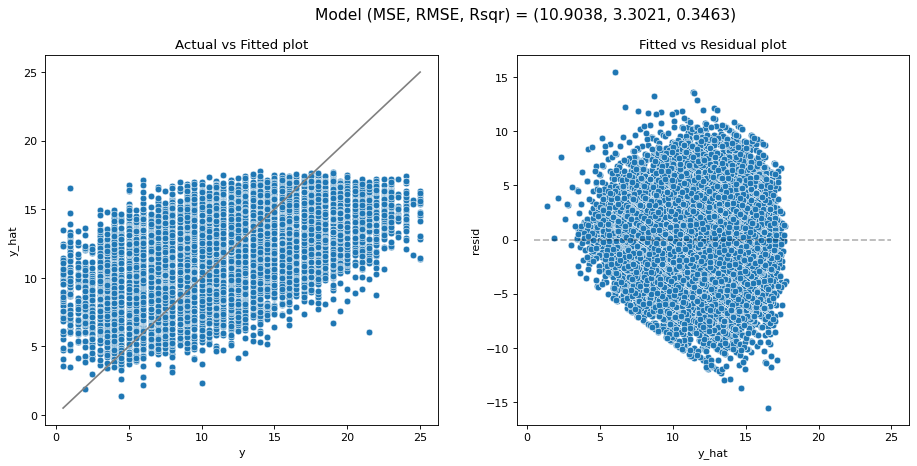

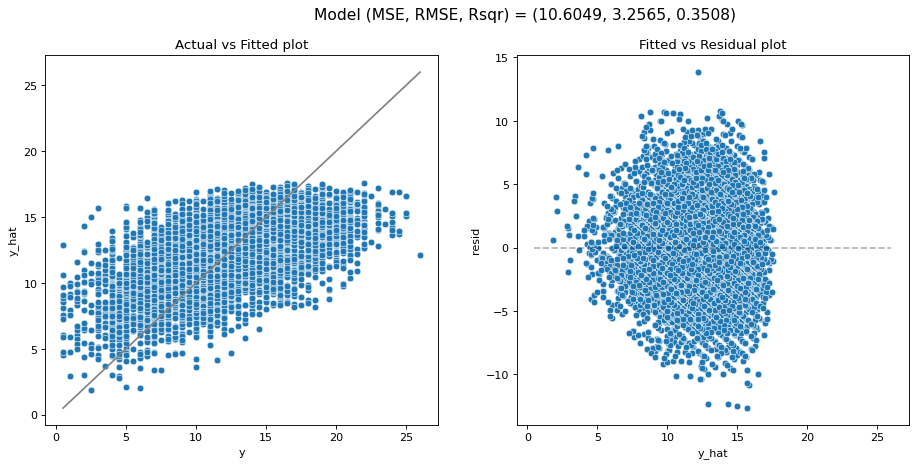

(10.6049, 3.2565, 0.3508)

In [42]:
# Sequential Feature Selection
#!pip install mlxtend
from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

onehot_encoder = OneHotEncoder()

encoder = ColumnTransformer([
    # pass through all columns with numerical values 
    ("num", "passthrough", [0,1,2,3,4,5,6,7,8,12,13,14]), 
    # apply the onehot_encoder to the last column
    ("cat", onehot_encoder, [9,10,11]),
]) 

X_train_1hot = encoder.fit_transform(X_train)
X_test_1hot = encoder.fit_transform(X_test)

sfs = SequentialFeatureSelector(LinearRegression(),
                                direction='forward',
                                scoring='neg_mean_squared_error')

reg_seq_sel = sfs.fit(X_train_1hot, y_train)
sel_cols = reg_seq_sel.get_support()

# I THINK THIS CAN BE REMOVED
# selector = LinearRegression().fit(X_train_1hot[:,sel_cols], y_train)
# print(round(selector.score(X_train_1hot[:,sel_cols], y_train), 3))

X_train_best = reg_seq_sel.transform(X_train_1hot)
X_test_best = reg_seq_sel.transform(X_test_1hot)

pf = PolynomialFeatures(include_bias=False)

# Overall ML pipeline
poly_pipe = Pipeline([
    ("poly", pf),
    ("model", LinearRegression())])

poly_model = poly_pipe.fit(X_train_best, y_train)

model_fit(poly_model, X_train_best, y_train, plot=True)
model_fit(poly_model, X_test_best, y_test, plot=True)

# I THINK THIS CAN BE REMOVED
# sel_cols
# sfs0 = SFS(knn, 
#           k_features=4, 
#           forward=True, 
#           floating=False, 
#           scoring='accuracy',
#           verbose=2,
#           cv=5)

# fig = plot_sfs(sfs0.get_metric_dict(), kind='std_err')

# plt.title('Sequential Forward Selection (w. StdErr)')
# plt.grid()
# plt.show()

# this gives us the same result as above so chuck this?
# sfs2 = SequentialFeatureSelector(LinearRegression(),
#                                 direction='backward',
#                                 scoring='r2')

# reg_seq_sel2 = sfs2.fit(X_train_1hot, y_train)
# sel_cols2 = reg_seq_sel2.get_support()

# print(sel_cols2)

# selector_lm2 = LinearRegression().fit(X_train_1hot[:,sel_cols2], y_train)
# print(round(selector_lm2.score(X_train_1hot[:,sel_cols2], y_train), 3))



In [39]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(estimator=LinearRegression()).fit(X_train_1hot, y_train)
# selector.estimator_.coef_
# selector.threshold_
# names = selector.get_feature_names_out()
# print(names)
# selector.get_support()
X_train_best = selector.transform(X_train_1hot)
X_test_best = selector.transform(X_test_1hot)


(9503, 9)

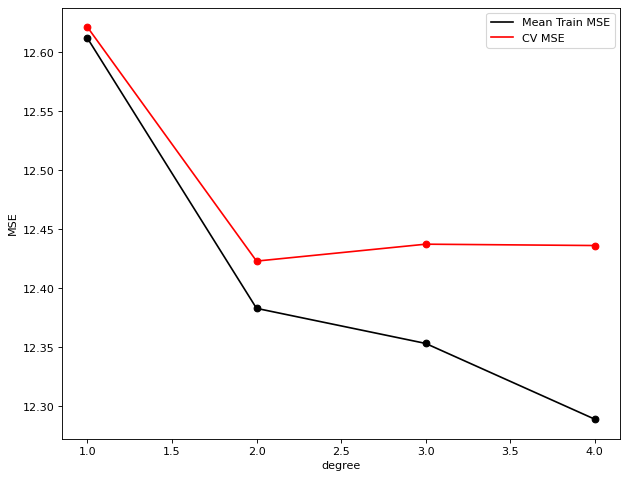

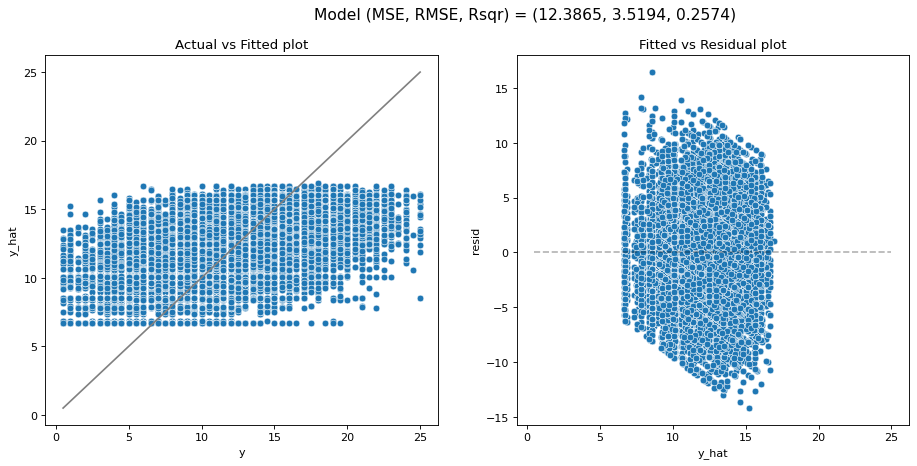

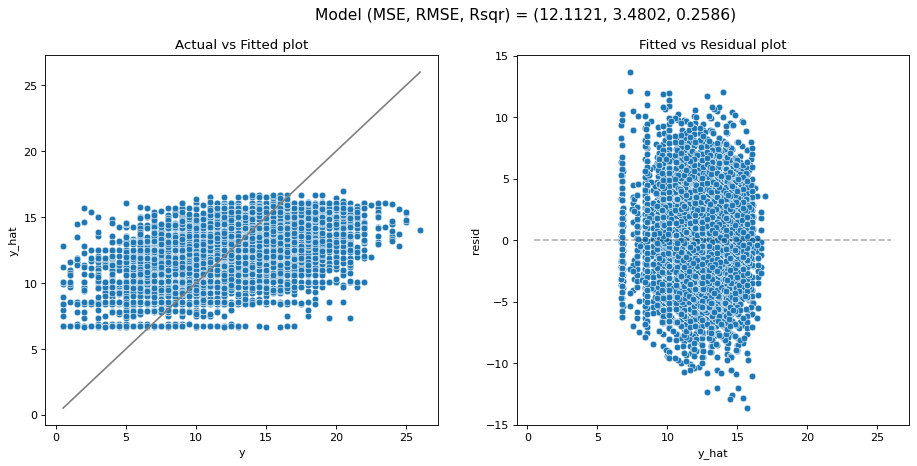

(12.1121, 3.4802, 0.2586)

In [31]:
pf = PolynomialFeatures(include_bias=False)

# Overall ML pipeline
poly_pipe = Pipeline([
    ("poly", pf),
    ("model", LinearRegression())])

# Parameters for grid search
parameters = {
    'poly__degree': np.arange(1, 5, 1)
}

kf = KFold(n_splits = 5, shuffle = True, random_state=rng)

# grid_search = GridSearchCV(poly_pipe, parameters, cv = kf, scoring = 'neg_mean_squared_error', return_train_score=True).fit(X_train_best, y_train)

# # The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting
# print("best index: ", grid_search.best_index_)
# # Parameter setting that gave the best results on the hold out data
# print("best param: ", grid_search.best_params_)
# # Mean cross-validated score of the best_estimator
# print("best score: ", grid_search.best_score_)

# pd.DataFrame(grid_search.cv_results_)

degree = np.arange(1, 5, 1)
fig, ax = plt.subplots(figsize=(9,7), ncols=1, nrows=1)
plt.scatter(degree,-grid_search.cv_results_['mean_train_score'], color='k')
plt.plot(degree,-grid_search.cv_results_['mean_train_score'], color='k', label='Mean Train MSE')
plt.scatter(degree,-grid_search.cv_results_['mean_test_score'], color='r')
plt.plot(degree,-grid_search.cv_results_['mean_test_score'], color='r', label='CV MSE')
ax.legend()
ax.set_xlabel('degree')
ax.set_ylabel('MSE')
plt.show()

# it seems like we should stick to degree 2
poly_model = poly_pipe.fit(X_train_best, y_train)

model_fit(poly_model, X_train_best, y_train, plot=True)
model_fit(poly_model, X_test_best, y_test, plot=True)


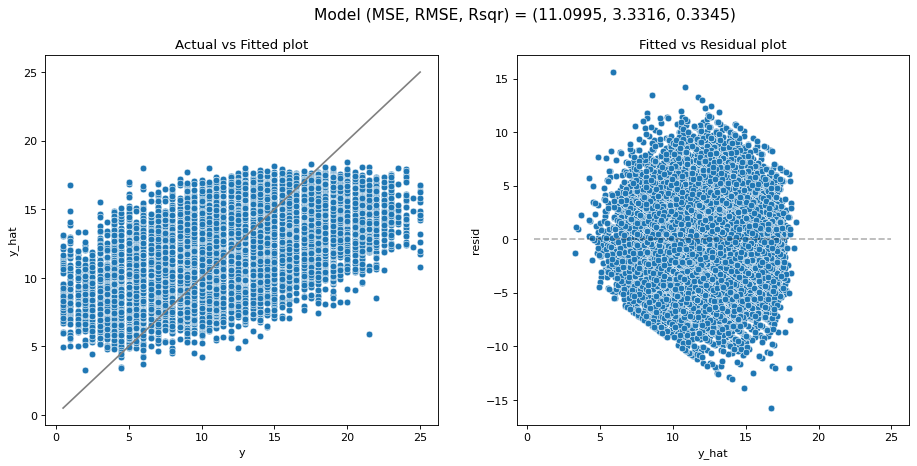

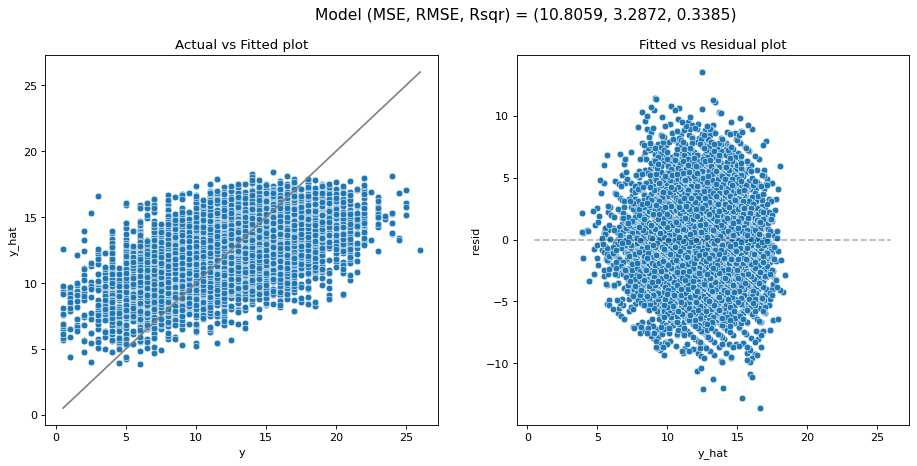

The best value of alpha = 2


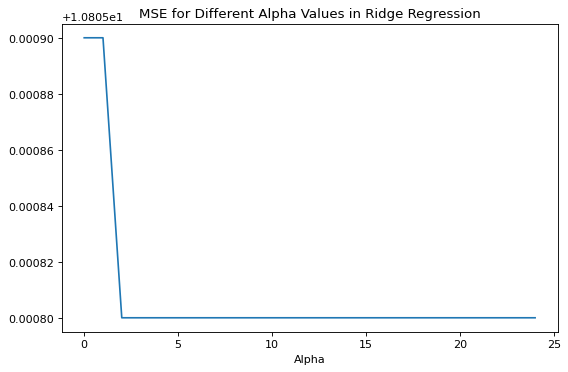

In [64]:
# Selected alpha value 
alpha_val = 2

r = make_pipeline(
    StandardScaler(),
    Ridge(alpha = alpha_val, random_state=rng)
).fit(X_train_best, y_train)

# print(np.c_[np.append(['intercept'],r.feature_names_in_),np.round(get_coefs(r),4)])

model_fit(r, X_train_best, y_train, plot = True)
model_fit(r, X_test_best, y_test, plot = True)

alpha_val = np.arange(1, 50, 2)
MSE = []

for alpha in alpha_val:
    r = make_pipeline(
        StandardScaler(),
        Ridge(alpha = alpha, random_state=rng)
    ).fit(X_train_best, y_train)

    MSE.append(model_fit(r, X_test_best, y_test)[0])

plt.plot(MSE)
plt.title("MSE for Different Alpha Values in Ridge Regression")
plt.xlabel("Alpha")

print(f"The best value of alpha = {np.argmin(MSE)}")


{'ridge__alpha': 85.90604026845638}
11.107269200168275


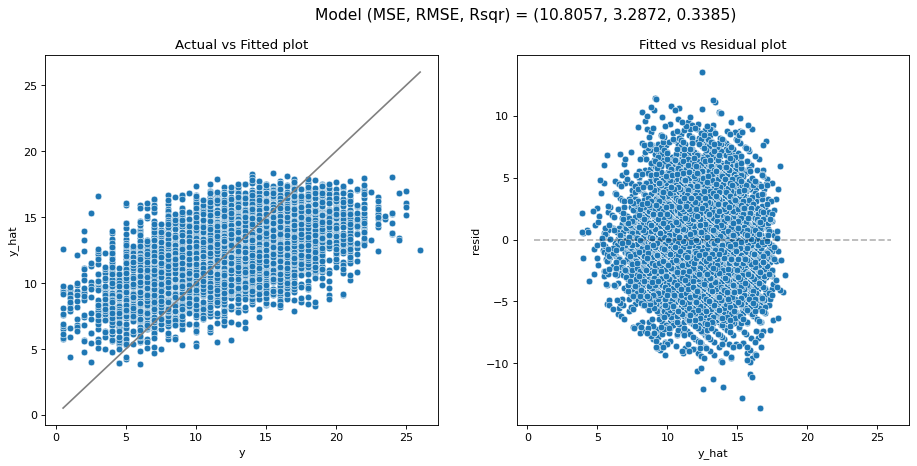

(10.8057, 3.2872, 0.3385)

In [74]:
# Grid of tuning parameters
alphas = np.linspace(0, 20, num=150)  

#Pipeline
ridge_pipe = make_pipeline(
        StandardScaler(),
        Ridge())

# CV strategy
cv = KFold(5, shuffle=True, random_state=rng)

# Grid search
gs = GridSearchCV(ridge_pipe,
    param_grid={'ridge__alpha': alphas},
    cv=cv,
    scoring="neg_mean_squared_error")

gs.fit(X_train_best, y_train)

print(gs.best_params_)
print(-gs.best_score_)

model_fit(gs.best_estimator_, X_test_best, y_test, plot=True)

The best value of alpha = 0


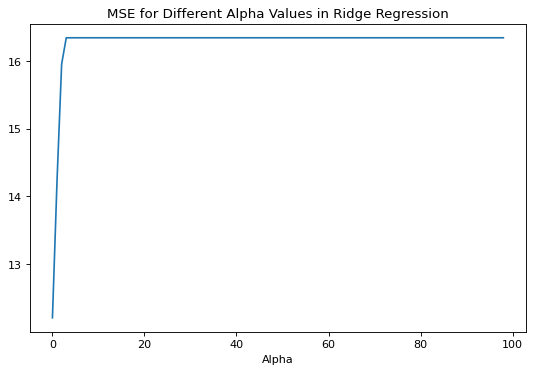

In [72]:
# ELASTIC NET DOESNT SEEM AS GOOD
alpha_val = 0.01

elastic_net = make_pipeline(
    StandardScaler(),
    ElasticNet(alpha = alpha_val, random_state=rng)
).fit(X_train_best, y_train)

# model_fit(elastic_net, X_train_best, y_train, plot = True)
# model_fit(elastic_net, X_test_best, y_test, plot = True)

alpha_val = np.arange(1, 100, 1)
MSE = []

for alpha in alpha_val:
    r = make_pipeline(
        StandardScaler(),
        ElasticNet(alpha = alpha, random_state=rng)
    ).fit(X_train_best, y_train)

    MSE.append(model_fit(r, X_test_best, y_test)[0])

plt.plot(MSE)
plt.title("MSE for Different Alpha Values in Ridge Regression")
plt.xlabel("Alpha")

print(f"The best value of alpha = {np.argmin(MSE)}")

Write :
- We tried Lasso and ElasticNet for a variety of alpha values but the metrics were either the same or worse than Ridge regression

0.0


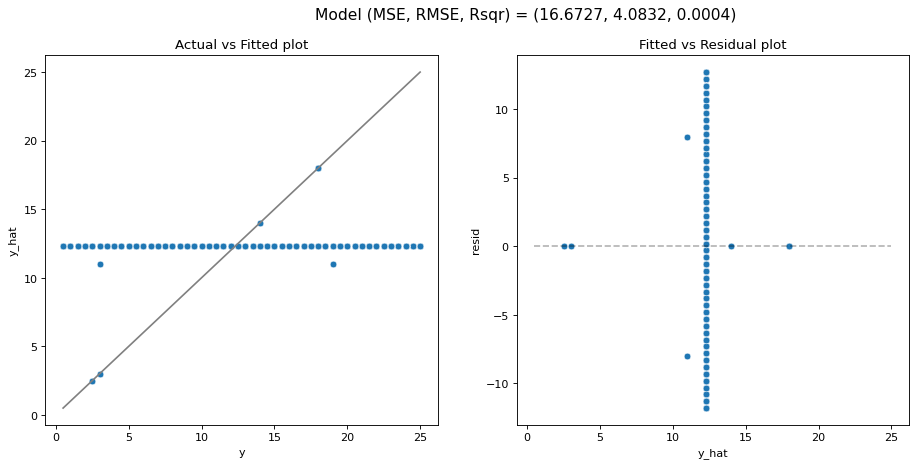

(16.6727, 4.0832, 0.0004)

In [44]:
# I DONT THINK WE NEED ANY OF THIS
# Selected alpha value 
alpha_val = 1

cat_pre = Pipeline([
    ("cat_encode", OneHotEncoder(drop='first'))])

num_pre = Pipeline([
    ("num_scale", StandardScaler(with_mean=False))])
    
r = Pipeline([
    ("cat_pre_processing", ColumnTransformer([("cat_pre", cat_pre, [1,3,4])])),
    ("num_pre_processing", ColumnTransformer([("num_pre", num_pre, [0,2,5,6,7,8])])),
    ("model", Ridge())
])
fitted_r = r.fit(X_train, y_train)
print(round(fitted_r.score(X_train, y_train), 3))
#print(np.c_[np.append(['intercept'],fitted_r.feature_names_in_),np.round(get_coefs(fitted_r),4)])

model_fit(fitted_r, X_train, y_train, plot = True)

# alpha_val = np.arange(1, 100, 1)
# MSE = []

# # # why the fuck does this look like this? it keeps decreasing so no local minimum?!
# for alpha in alpha_val:
#     r0 = Pipeline([
#     ("cat_pre_processing", ColumnTransformer([("cat_pre", cat_pre, [1,3,4])])),
#     ("num_pre_processing", ColumnTransformer([("num_pre", num_pre, [0,2,5,6,7,8])])),
#     ("model", Ridge(alpha = alpha))]).fit(X_train, y_train)

#     MSE.append(model_fit(r0, X_test, y_test)[0])

# plt.plot(MSE)
# plt.title("MSE for Different Alpha Values in Ridge Regression")
# plt.xlabel("Alpha")



In [49]:
# Xs = StandardScaler().fit_transform(X_train_1hot)
# l1r = [.1, .5, .9, 1]
# fig, ax = plt.subplots(1,4,figsize= (15,6))
# for i, l in enumerate(l1r):
#     sol_path = ElasticNet.path(Xs, y_train, l1_ratio=l)
#     d = pd.DataFrame(data = sol_path[1].T, columns = X_train_1hot.columns, index = sol_path[0])
#     d.plot(ax=ax[i]) 


# # Grid of tuning parameters
# nalphas = 100 
# l1r = [0.01, .1, .5, .7, .9, .95, 1]

# # CV strategy
# cv = KFold(5, shuffle=True, random_state=rng)

# # lasso CV
# ecv = ElasticNetCV(n_alphas=nalphas, l1_ratio=l1r, cv=cv)

# #Pipeline
# gs_en = make_pipeline(
#         StandardScaler(),
#         ecv)
# gs_en.fit(X_train_1hot, y_train)

# print( "l1_ratio:", gs_en['elasticnetcv'].l1_ratio_)
# print( "alpha:", gs_en['elasticnetcv'].alpha_)
# print( "minimum value of alpha in the grid:", np.min(gs_en['elasticnetcv'].alphas_))

# cv_mse_en = np.mean(gs_en["elasticnetcv"].mse_path_,axis=2)
# print('CV MSE for elasticnet model', round(np.min(cv_mse_en),4))
# print('CV MSE for ridge model',round(-gs.best_score_,4))

ValueError: could not convert string to float: 'obese'

# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a government official or charity directy, who is understands the pressing challenges associated with ageining and dementia but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also mention potential limitations of your model.*

*Finally, you should include recommendations on potential lifestyle changes or governmental/societal interventions to reduce dementia risk.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

# References

<sup>1</sup> "World Population Prospects 2022, Summary of Results", United Nations, accessed February 29, 2024, *https://www.un.org/development/desa/pd/sites/www.un.org.development.desa.pd/files/wpp2022_summary_of_results.pdf*.

<sup>2</sup> "Ageing and Health", World Health Organization, accessed February 29, 2024, *https://www.who.int/news-room/fact-sheets/detail/ageing-and-health#:~:text=Every%20country%20in%20the%20world,in%202020%20to%201.4%20billion.*.

<sup>3</sup> "Dementia", World Health Organization, accessed February 29, 2024, *https://www.who.int/news-room/facts-in-pictures/detail/dementia*.

<sup>4</sup> "Dementia", World Health Organization, accessed February 29, 2024, *https://www.who.int/news-room/facts-in-pictures/detail/dementia*.

<sup>5</sup> Page 123, Feature Engineering and Selection, 2019, accessed March 5, 2024, *https://shorturl.at/mCKNX*.

<sup>6</sup> "Avoid Mistakes in Machine Learning Models with Skewed Count Data", Medium, accessed March 4, 2024, *https://medium.com/p/e3512b94d745*. 

<sup>7</sup> "Avoid Mistakes in Machine Learning Models with Skewed Count Data", Medium, accessed March 4, 2024, *https://medium.com/p/e3512b94d745*. 

"Discussion on handling ordinal categorical vars: https://www3.nd.edu/~rwilliam/stats3/OrdinalIndependent.pdf,\n we do not need to convert with OneHotEncoder unless we are using interaction terms."

In [ ]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project1.ipynb

[NbConvertApp] Converting notebook project1.ipynb to pdf
[NbConvertApp] ERROR | Error while converting 'project1.ipynb'
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/nbconvert/nbconvertapp.py", line 487, in export_single_notebook
    output, resources = self.exporter.from_filename(
  File "/home/codespace/.local/lib/python3.10/site-packages/nbconvert/exporters/templateexporter.py", line 386, in from_filename
    return super().from_filename(filename, resources, **kw)  # type:ignore[return-value]
  File "/home/codespace/.local/lib/python3.10/site-packages/nbconvert/exporters/exporter.py", line 201, in from_filename
    return self.from_file(f, resources=resources, **kw)
  File "/home/codespace/.local/lib/python3.10/site-packages/nbconvert/exporters/templateexporter.py", line 392, in from_file
    return super().from_file(file_stream, resources, **kw)  # type:ignore[return-value]
  File "/home/codespace/.local/lib/python3.10/site-packages/